In [1]:
#!pip install openassetpricing

In [2]:
import pandas as pd
import numpy as np
import openassetpricing as oap
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
linear_r = LinearRegression()
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
!pip install shap
import shap

MLP = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)

# Initialize OpenAP using the 2024 data release 
openap = oap.OpenAP()

In [3]:
pd.options.display.max_columns = 100

In [4]:
signal_df = openap.dl_signal_doc('pandas')


## Sampling out 10 random, with quality good, and T-stat > 3 (statistical significance)


In [5]:
signal_df['T-Stat'] = pd.to_numeric(signal_df['T-Stat'], errors='coerce')
good_signals_df = signal_df[signal_df['Signal Rep Quality'] == '1_good']

strong_signals_df = good_signals_df[good_signals_df['T-Stat'] > 3]

sampled_strong_signals = strong_signals_df.sample(n=20, random_state=42)
sampled_strong_acronyms = sampled_strong_signals['Acronym'].tolist()

sampled_strong_signals
filtered_signals_reset = sampled_strong_signals.reset_index(drop=True)
filtered_signals_reset[['Acronym', 'Signal Rep Quality', 'Return', 'T-Stat']]



,Acronym,Signal Rep Quality,Return,T-Stat
0,VolSD,1_good,NA,3.560000
1,CashProd,1_good,NA,3.600000
2,AnnouncementReturn,1_good,NA,9.250000
3,ResidualMomentum,1_good,0.933333333,8.218550
4,Tax,1_good,NA,3.851000
5,MomRev,1_good,0.48,4.290000
6,DelFINL,1_good,NA,8.010000
7,DivSeason,1_good,0.36,16.193631
8,std_turn,1_good,NA,3.740000
9,CBOperProf,1_good,0.47,3.170000


In [6]:
signals = filtered_signals_reset['Acronym'].tolist() 

In [7]:
port_vw = openap.dl_port('deciles_vw', 'pandas', signals)
ls_df = port_vw[port_vw['port'] == 'LS']

One or more input predictors are not available.

Data is downloaded: 5s


In [8]:
ls_df

,signalname,port,date,ret,signallag,Nlong,Nshort
8580,Accruals,LS,1952-07-31,-3.377266,NaN,30,30
8581,Accruals,LS,1952-08-29,-1.113506,NaN,30,30
8582,Accruals,LS,1952-09-30,0.153144,NaN,30,30
8583,Accruals,LS,1952-10-31,1.419055,NaN,30,30
8584,Accruals,LS,1952-11-28,-4.619310,NaN,30,30
...,...,...,...,...,...,...,...
178172,std_turn,LS,2023-08-31,19.648386,NaN,68,68
178173,std_turn,LS,2023-09-29,2.052333,NaN,68,68
178174,std_turn,LS,2023-10-31,4.101759,NaN,67,67
178175,std_turn,LS,2023-11-30,1.444660,NaN,67,67


In [9]:
ls_matrix = ls_df.pivot(index='date', columns='signalname', values='ret')
ls_matrix

signalname,Accruals,AnnouncementReturn,CBOperProf,CashProd,ChTax,DelFINL,Frontier,IdioVol3F,InvestPPEInv,MomOffSeason16YrPlus,MomSeason06YrPlus,PctTotAcc,PriceDelayRsq,ResidualMomentum,Tax,VolSD,grcapx,std_turn
date,,,,,,,,,,,,,,,,,,
1926-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.745537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.319781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.124391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.516864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.361217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,3.106883,4.034015,8.692678,-2.051515,4.474620,2.073515,-7.184456,14.532055,3.749577,-2.270017,0.663238,5.911328,-1.02598,2.132615,3.824418,4.199129,6.856208,19.648386
2023-09-29,1.678011,3.676167,1.471704,2.563171,1.398408,2.463867,-2.196534,3.126289,0.783225,0.116894,-0.457575,-1.205752,NaN,0.042501,0.135734,0.693913,3.181883,2.052333
2023-10-31,1.210641,3.689313,10.287946,2.195539,3.521295,3.464506,-12.219612,14.780665,1.735352,-2.700827,3.971866,2.763062,NaN,-0.380778,0.421685,-0.481252,4.148699,4.101759


In [10]:
ls_zscore = (ls_matrix - ls_matrix.mean()) / ls_matrix.std()
ls_zscore

signalname,Accruals,AnnouncementReturn,CBOperProf,CashProd,ChTax,DelFINL,Frontier,IdioVol3F,InvestPPEInv,MomOffSeason16YrPlus,MomSeason06YrPlus,PctTotAcc,PriceDelayRsq,ResidualMomentum,Tax,VolSD,grcapx,std_turn
date,,,,,,,,,,,,,,,,,,
1926-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.179820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.245085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.521041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.828881,0.842651,2.118861,-0.579303,1.130381,0.775264,-1.135629,1.686440,0.895563,-0.705077,0.030347,1.950786,-0.173342,0.386403,1.203209,1.055544,1.743736,2.739837
2023-09-29,0.390730,0.739689,0.250333,0.640338,0.283183,0.932436,-0.379695,0.279318,0.080564,-0.030539,-0.253886,-0.476872,NaN,-0.146088,-0.033299,0.121899,0.779882,0.231169
2023-10-31,0.247415,0.743471,2.531659,0.543175,0.867832,1.335334,-1.898722,1.717111,0.342159,-0.826823,0.869401,0.876903,NaN,-0.253925,0.062556,-0.191117,1.033498,0.523355


In [11]:
weights = filtered_signals_reset.set_index('Acronym')['T-Stat']
weights_aligned = weights.reindex(ls_zscore.columns).fillna(0)
weights_normalized = weights_aligned / weights_aligned.sum()
composite_signal = ls_zscore.dot(weights_normalized)
composite_signal = composite_signal.dropna()

In [14]:
actual_ls_return = ls_matrix.mean(axis=1)
aligned = pd.concat([composite_signal, actual_ls_return.shift(-1)], axis=1).dropna()
aligned.columns = ['predicted', 'actual']

print(aligned.corr())

           predicted    actual
predicted   1.000000  0.054496
actual      0.054496  1.000000


In [ ]:
#!pip install xgboost

In [15]:
algos = [linear_r, rf, xgb_model, svr, MLP]

X = ls_zscore.shift(1).dropna()  
y = ls_matrix.mean(axis=1).loc[X.index] 


In [16]:
def summary_stats(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    t_stat = mean / (std / np.sqrt(len(series)))
    print(f"  Mean Return: {mean:.4f}")
    print(f"  Volatility: {std:.4f}")
    print(f"  Sharpe Ratio: {sharpe:.4f}")
    print(f"  T-Statistic: {t_stat:.4f}")
    print(f"  Start Date: {series.index.min()}")
    print(f"  End Date: {series.index.max()}")
    print("-" * 50)
    return " "

summary_stats(composite_signal)

  Mean Return: -0.0181
  Volatility: 0.3485
  Sharpe Ratio: -0.0520
  T-Statistic: -1.0685
  Start Date: 1988-07-29 00:00:00
  End Date: 2023-08-31 00:00:00
--------------------------------------------------


' '

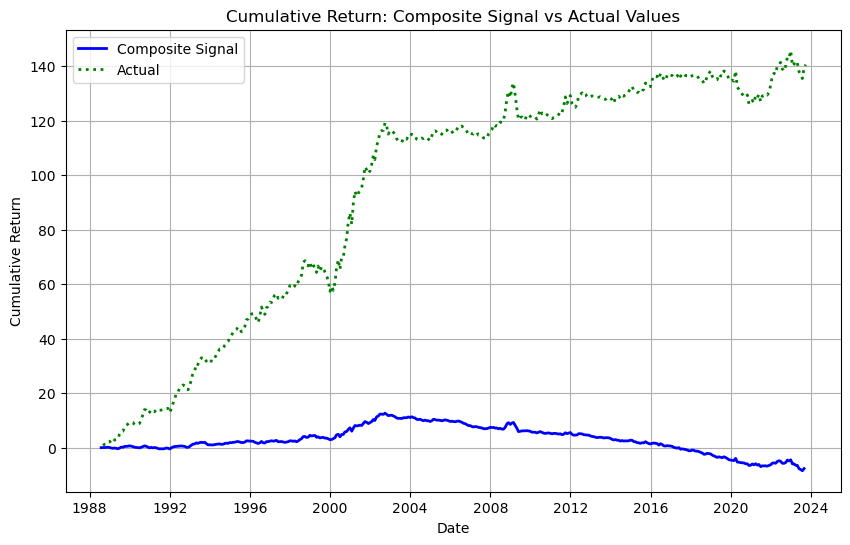

Correlation: 0.07475378104717759
Mean Squared Error: 10292.946609407807


In [21]:
composite_cumulative_return = composite_signal.cumsum()
actual_cumulative_return = y.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(composite_cumulative_return.index, composite_cumulative_return, label="Composite Signal", color='blue', linestyle='-', linewidth=2)
plt.plot(actual_cumulative_return.index, actual_cumulative_return, label="Actual", color='green', linestyle=':', linewidth=2)
plt.title("Cumulative Return: Composite Signal vs Actual Values")
plt.xlabel("Date")  # or "Index" if you're using indices
plt.ylabel("Cumulative Return")
plt.legend(loc='best')

plt.grid(True)
plt.show()

correlation = composite_cumulative_return.corr(actual_cumulative_return)
mse = mean_squared_error(actual_cumulative_return, composite_cumulative_return)

print(f"Correlation: {correlation}")
print(f"Mean Squared Error: {mse}")

LinearRegression
  Mean Squared Error: 2.415166968366452
  Correlation: 0.22355218063680687
  Mean Return: 0.3330
  Volatility: 0.3569
  Sharpe Ratio: 0.9331
  T-Statistic: 19.1680
  Start Date: 1988-08-31 00:00:00
  End Date: 2023-09-29 00:00:00
--------------------------------------------------
 
RandomForestRegressor
  Mean Squared Error: 0.3958228631588693
  Correlation: 0.9794876254154611
  Mean Return: 0.3336
  Volatility: 1.0220
  Sharpe Ratio: 0.3264
  T-Statistic: 6.7052
  Start Date: 1988-08-31 00:00:00
  End Date: 2023-09-29 00:00:00
--------------------------------------------------
 
XGBRegressor
  Mean Squared Error: 5.774654509616573e-07
  Correlation: 0.9999998975117644
  Mean Return: 0.3330
  Volatility: 1.5961
  Sharpe Ratio: 0.2086
  T-Statistic: 4.2857
  Start Date: 1988-08-31 00:00:00
  End Date: 2023-09-29 00:00:00
--------------------------------------------------
 
SVR
  Mean Squared Error: 1.6646331924873583
  Correlation: 0.7200805006773644
  Mean Return: 0.22

C:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor
  Mean Squared Error: 0.2852007032352579
  Correlation: 0.9454192406488432
  Mean Return: 0.3151
  Volatility: 1.3868
  Sharpe Ratio: 0.2272
  T-Statistic: 4.6673
  Start Date: 1988-08-31 00:00:00
  End Date: 2023-09-29 00:00:00
--------------------------------------------------
 


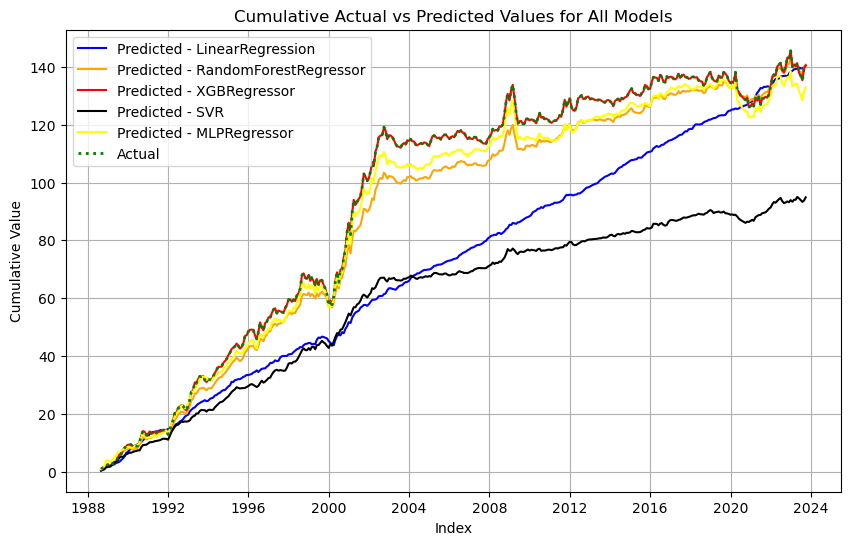

In [20]:
plt.figure(figsize=(10, 6))

colors = {
    "LinearRegression": 'blue',
    "RandomForestRegressor": 'orange',
    "XGBRegressor": 'red',
    "SVR": 'black',
    "MLPRegressor": 'yellow'
}
for algo in algos:
    algo.fit(X, y)
    y_test_pred = pd.Series(algo.predict(X), index=X.index)
    print(type(algo).__name__)
    print(f"  Mean Squared Error: {mean_squared_error(y, y_test_pred)}")
    print(f"  Correlation: {y_test_pred.corr(y)}")
    print(summary_stats(y_test_pred))
    plt.plot(y_test_pred.index, y_test_pred.cumsum(), label=f"Predicted - {type(algo).__name__}", color=colors[type(algo).__name__])

plt.plot(y.index, y.cumsum(), label="Actual", color='green', linewidth=2, linestyle=':')
plt.title("Cumulative Actual vs Predicted Values for All Models")
plt.xlabel("Index")
plt.ylabel("Cumulative Value")
plt.legend()  
plt.grid(True) 
plt.show()

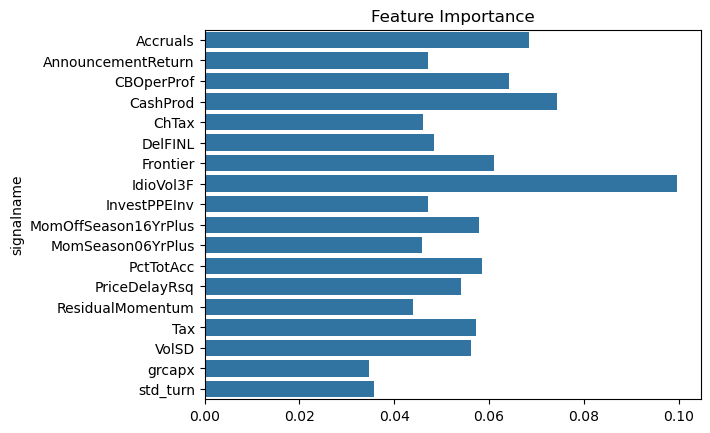

In [22]:
import seaborn as sns

feature_importance = rf.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title("Feature Importance")
plt.show()

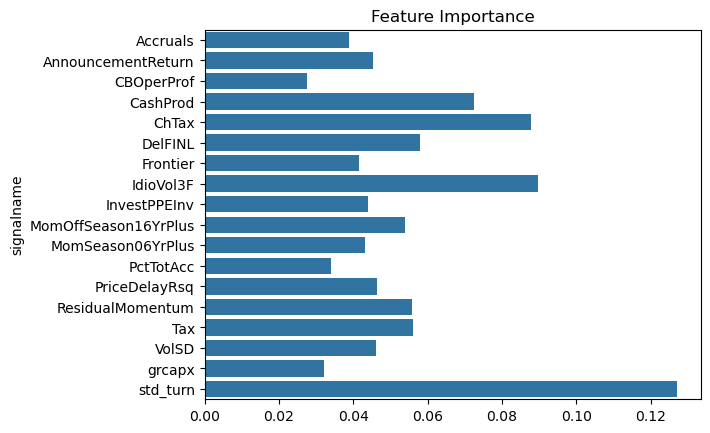

In [23]:
feature_importance = xgb_model.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title("Feature Importance")
plt.show()